In [2]:
# tested on python 3.8 only!

import tensorflow as tf
import tensorflow_datasets as tfds

import time
import numpy as np
import matplotlib.pyplot as plt

In [31]:
# getting training data first

examples, metadata = tfds.load('wmt14_translate/de-en', with_info=True, as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Shuffling and writing examples to /home/rottmann/tensorflow_datasets/wmt14_translate/de-en/1.0.0.incomplete82OJKW/wmt14_translate-train.tfrecord


Shuffling and writing examples to /home/rottmann/tensorflow_datasets/wmt14_translate/de-en/1.0.0.incomplete82OJKW/wmt14_translate-validation.tfrecord


Shuffling and writing examples to /home/rottmann/tensorflow_datasets/wmt14_translate/de-en/1.0.0.incomplete82OJKW/wmt14_translate-test.tfrecord


Dataset wmt14_translate downloaded and prepared to /home/rottmann/tensorflow_datasets/wmt14_translate/de-en/1.0.0. Subsequent calls will reuse this data.


In [84]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for _, en in train_examples), target_vocab_size=2**13)

tokenizer_de = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (de.numpy() for de, _ in train_examples), target_vocab_size=2**13)


In [85]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))


Tokenized string is [3970, 1803, 9, 2804, 94, 4050, 7971]
The original string: Transformer is awesome.
3970 ----> Trans
1803 ----> former 
9 ----> is 
2804 ----> aw
94 ----> es
4050 ----> ome
7971 ----> .


In [86]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64


def encode(lang1, lang2):
  lang1 = [tokenizer_de.vocab_size] + tokenizer_de.encode(
      lang1.numpy()) + [tokenizer_de.vocab_size+1]

  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
  return lang1, lang2

def tf_encode(de, en):
  result_de, result_en = tf.py_function(encode, [de, en], [tf.int64, tf.int64])
  result_de.set_shape([None])
  result_en.set_shape([None])

  return result_de, result_en

In [87]:
MAX_LENGTH = 20
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)


In [88]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)


In [89]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 20), dtype=int64, numpy=
 array([[8262,  329,   49, ...,    0,    0,    0],
        [8262,   64,   75, ...,    0,    0,    0],
        [8262, 4522,   15, ...,    0,    0,    0],
        ...,
        [8262,  290, 4862, ...,    0,    0,    0],
        [8262,  329,  102, ...,    0,    0,    0],
        [8262, 1120, 2883, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 20), dtype=int64, numpy=
 array([[8181, 1299,  436, ...,    0,    0,    0],
        [8181,   52, 7860, ...,    0,    0,    0],
        [8181, 2971,    1, ...,    0,    0,    0],
        ...,
        [8181,   14, 1664, ...,    0,    0,    0],
        [8181, 1299,   38, ...,    0,    0,    0],
        [8181, 4836, 7299, ...,    0,    0,    0]])>)

In [29]:
# PE(pos, 2i) = sin(pos/(10000^{2i/d_model}))
# PE(pos, 2i+1)= cos(pos/(10000^{2i/d_model}))
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

def test_positional_encoding():
    POSITIONS = 80
    DIMS = 256
    pos_encodings = positional_encoding(POSITIONS, DIMS)
    POS = 10
    DIM = 11
    assert(pos_encodings[0, 10, 11] == np.cos(POS * 1./np.power(10000, (2 * (DIM//2) / np.float32(DIMS)))))


(1, 50, 512)


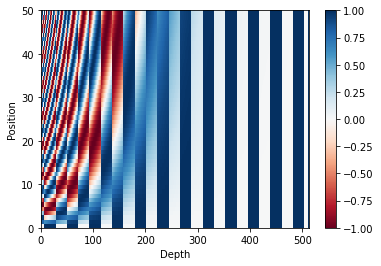

In [30]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

test_positional_encoding()

In [49]:
# masking for padded sequence

def create_padding_mask(sequence):
    mask = tf.cast(tf.math.equal(sequence, 0), dtype=tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]


def test_padding_mask():
    test_sequence = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 4, 0], [0, 1, 2, 3, 0]])
    padding_mask = create_padding_mask(test_sequence)
    print(padding_mask)
    assert (tf.reduce_all(tf.math.equal(padding_mask, tf.convert_to_tensor([
        [[[0, 0, 1, 1, 0]]],
        [[[0, 0, 0, 0, 1]]],
        [[[1, 0, 0, 0, 1]]]], dtype=tf.float32))))
    

test_padding_mask()
    

tf.Tensor(
[[[[0. 0. 1. 1. 0.]]]


 [[[0. 0. 0. 0. 1.]]]


 [[[1. 0. 0. 0. 1.]]]], shape=(3, 1, 1, 5), dtype=float32)


In [103]:
# masking for look_ahead (we don't want to look into the future!)
def create_look_ahead_mask(size):
    matrix = tf.ones((size,size), dtype=tf.float32)
    return 1 - tf.linalg.band_part(matrix, -1, 0)

def test_lookahead_mask():
    lookahead_mask = create_look_ahead_mask(4)
    print(lookahead_mask)
    assert(tf.reduce_all(tf.math.equal(lookahead_mask, tf.convert_to_tensor([
        [0, 1, 1, 1],
        [0, 0, 1, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 0]], dtype=tf.float32))))

test_lookahead_mask()
    

tf.Tensor(
[[0. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]], shape=(4, 4), dtype=float32)


In [65]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)


np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)


Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [66]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [67]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [71]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [72]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [73]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)


TensorShape([64, 43, 512])

In [74]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [75]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)


TensorShape([64, 50, 512])

In [76]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)


In [77]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)


(64, 62, 512)


In [78]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [79]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [80]:
# the full transformer!

class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [81]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)


TensorShape([64, 36, 8000])

In [90]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_de.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1



In [91]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [92]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)


Text(0.5, 0, 'Train Step')

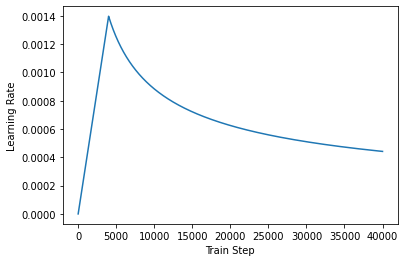

In [93]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")


In [94]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


In [95]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


In [96]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')


In [97]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)


In [98]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [99]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')


In [105]:
EPOCHS = 20
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

inp = None
tar = None

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)


In [106]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  batch = 0
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 9.0097 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.9493 Accuracy 0.0091
Epoch 1 Batch 100 Loss 8.8611 Accuracy 0.0305
Epoch 1 Batch 150 Loss 8.7690 Accuracy 0.0378
Epoch 1 Batch 200 Loss 8.6580 Accuracy 0.0416
Epoch 1 Batch 250 Loss 8.5246 Accuracy 0.0444
Epoch 1 Batch 300 Loss 8.3710 Accuracy 0.0507
Epoch 1 Batch 350 Loss 8.2106 Accuracy 0.0566
Epoch 1 Batch 400 Loss 8.0498 Accuracy 0.0612
Epoch 1 Batch 450 Loss 7.9028 Accuracy 0.0655
Epoch 1 Batch 500 Loss 7.7680 Accuracy 0.0703
Epoch 1 Batch 550 Loss 7.6438 Accuracy 0.0749
Epoch 1 Batch 600 Loss 7.5240 Accuracy 0.0794
Epoch 1 Batch 650 Loss 7.4093 Accuracy 0.0837
Epoch 1 Batch 700 Loss 7.3034 Accuracy 0.0876
Epoch 1 Batch 750 Loss 7.2031 Accuracy 0.0916
Epoch 1 Batch 800 Loss 7.1063 Accuracy 0.0957
Epoch 1 Batch 850 Loss 7.0151 Accuracy 0.0996
Epoch 1 Batch 900 Loss 6.9281 Accuracy 0.1034
Epoch 1 Batch 950 Loss 6.8464 Accuracy 0.1070
Epoch 1 Batch 1000 Loss 6.7691 Accuracy 0.1105
Epoch 1 Batch 1050 Loss 6.6952 Accur

Epoch 1 Batch 8750 Loss 4.0324 Accuracy 0.2707
Epoch 1 Batch 8800 Loss 4.0258 Accuracy 0.2712
Epoch 1 Batch 8850 Loss 4.0193 Accuracy 0.2717
Epoch 1 Batch 8900 Loss 4.0129 Accuracy 0.2721
Epoch 1 Batch 8950 Loss 4.0063 Accuracy 0.2726
Epoch 1 Batch 9000 Loss 4.0000 Accuracy 0.2731
Epoch 1 Batch 9050 Loss 3.9937 Accuracy 0.2736
Epoch 1 Batch 9100 Loss 3.9873 Accuracy 0.2741
Epoch 1 Batch 9150 Loss 3.9809 Accuracy 0.2745
Epoch 1 Batch 9200 Loss 3.9746 Accuracy 0.2750
Epoch 1 Batch 9250 Loss 3.9682 Accuracy 0.2755
Epoch 1 Batch 9300 Loss 3.9618 Accuracy 0.2759
Epoch 1 Batch 9350 Loss 3.9555 Accuracy 0.2764
Epoch 1 Batch 9400 Loss 3.9496 Accuracy 0.2769
Epoch 1 Batch 9450 Loss 3.9438 Accuracy 0.2773
Epoch 1 Batch 9500 Loss 3.9379 Accuracy 0.2777
Epoch 1 Batch 9550 Loss 3.9316 Accuracy 0.2782
Epoch 1 Batch 9600 Loss 3.9256 Accuracy 0.2786
Epoch 1 Batch 9650 Loss 3.9197 Accuracy 0.2791
Epoch 1 Batch 9700 Loss 3.9138 Accuracy 0.2795
Epoch 1 Batch 9750 Loss 3.9079 Accuracy 0.2799
Epoch 1 Batch

Epoch 2 Batch 7150 Loss 2.5497 Accuracy 0.3840
Epoch 2 Batch 7200 Loss 2.5487 Accuracy 0.3840
Epoch 2 Batch 7250 Loss 2.5479 Accuracy 0.3841
Epoch 2 Batch 7300 Loss 2.5471 Accuracy 0.3842
Epoch 2 Batch 7350 Loss 2.5464 Accuracy 0.3843
Epoch 2 Batch 7400 Loss 2.5455 Accuracy 0.3844
Epoch 2 Batch 7450 Loss 2.5446 Accuracy 0.3845
Epoch 2 Batch 7500 Loss 2.5437 Accuracy 0.3846
Epoch 2 Batch 7550 Loss 2.5426 Accuracy 0.3847
Epoch 2 Batch 7600 Loss 2.5417 Accuracy 0.3848
Epoch 2 Batch 7650 Loss 2.5408 Accuracy 0.3848
Epoch 2 Batch 7700 Loss 2.5396 Accuracy 0.3849
Epoch 2 Batch 7750 Loss 2.5387 Accuracy 0.3850
Epoch 2 Batch 7800 Loss 2.5381 Accuracy 0.3851
Epoch 2 Batch 7850 Loss 2.5370 Accuracy 0.3852
Epoch 2 Batch 7900 Loss 2.5361 Accuracy 0.3853
Epoch 2 Batch 7950 Loss 2.5348 Accuracy 0.3854
Epoch 2 Batch 8000 Loss 2.5338 Accuracy 0.3855
Epoch 2 Batch 8050 Loss 2.5329 Accuracy 0.3855
Epoch 2 Batch 8100 Loss 2.5318 Accuracy 0.3856
Epoch 2 Batch 8150 Loss 2.5309 Accuracy 0.3857
Epoch 2 Batch

Epoch 3 Batch 5550 Loss 2.2896 Accuracy 0.4079
Epoch 3 Batch 5600 Loss 2.2894 Accuracy 0.4079
Epoch 3 Batch 5650 Loss 2.2890 Accuracy 0.4080
Epoch 3 Batch 5700 Loss 2.2885 Accuracy 0.4080
Epoch 3 Batch 5750 Loss 2.2880 Accuracy 0.4081
Epoch 3 Batch 5800 Loss 2.2874 Accuracy 0.4081
Epoch 3 Batch 5850 Loss 2.2875 Accuracy 0.4081
Epoch 3 Batch 5900 Loss 2.2870 Accuracy 0.4081
Epoch 3 Batch 5950 Loss 2.2862 Accuracy 0.4082
Epoch 3 Batch 6000 Loss 2.2859 Accuracy 0.4082
Epoch 3 Batch 6050 Loss 2.2851 Accuracy 0.4083
Epoch 3 Batch 6100 Loss 2.2847 Accuracy 0.4084
Epoch 3 Batch 6150 Loss 2.2842 Accuracy 0.4084
Epoch 3 Batch 6200 Loss 2.2842 Accuracy 0.4084
Epoch 3 Batch 6250 Loss 2.2838 Accuracy 0.4085
Epoch 3 Batch 6300 Loss 2.2834 Accuracy 0.4085
Epoch 3 Batch 6350 Loss 2.2828 Accuracy 0.4086
Epoch 3 Batch 6400 Loss 2.2821 Accuracy 0.4086
Epoch 3 Batch 6450 Loss 2.2818 Accuracy 0.4087
Epoch 3 Batch 6500 Loss 2.2813 Accuracy 0.4087
Epoch 3 Batch 6550 Loss 2.2809 Accuracy 0.4087
Epoch 3 Batch

Epoch 4 Batch 3950 Loss 2.1687 Accuracy 0.4199
Epoch 4 Batch 4000 Loss 2.1687 Accuracy 0.4199
Epoch 4 Batch 4050 Loss 2.1686 Accuracy 0.4199
Epoch 4 Batch 4100 Loss 2.1684 Accuracy 0.4199
Epoch 4 Batch 4150 Loss 2.1682 Accuracy 0.4199
Epoch 4 Batch 4200 Loss 2.1680 Accuracy 0.4199
Epoch 4 Batch 4250 Loss 2.1677 Accuracy 0.4199
Epoch 4 Batch 4300 Loss 2.1671 Accuracy 0.4199
Epoch 4 Batch 4350 Loss 2.1668 Accuracy 0.4200
Epoch 4 Batch 4400 Loss 2.1668 Accuracy 0.4200
Epoch 4 Batch 4450 Loss 2.1669 Accuracy 0.4200
Epoch 4 Batch 4500 Loss 2.1668 Accuracy 0.4200
Epoch 4 Batch 4550 Loss 2.1662 Accuracy 0.4200
Epoch 4 Batch 4600 Loss 2.1659 Accuracy 0.4200
Epoch 4 Batch 4650 Loss 2.1661 Accuracy 0.4200
Epoch 4 Batch 4700 Loss 2.1662 Accuracy 0.4201
Epoch 4 Batch 4750 Loss 2.1657 Accuracy 0.4201
Epoch 4 Batch 4800 Loss 2.1651 Accuracy 0.4201
Epoch 4 Batch 4850 Loss 2.1651 Accuracy 0.4201
Epoch 4 Batch 4900 Loss 2.1648 Accuracy 0.4202
Epoch 4 Batch 4950 Loss 2.1645 Accuracy 0.4202
Epoch 4 Batch

Epoch 5 Batch 2350 Loss 2.0912 Accuracy 0.4276
Epoch 5 Batch 2400 Loss 2.0907 Accuracy 0.4276
Epoch 5 Batch 2450 Loss 2.0908 Accuracy 0.4277
Epoch 5 Batch 2500 Loss 2.0910 Accuracy 0.4277
Epoch 5 Batch 2550 Loss 2.0909 Accuracy 0.4278
Epoch 5 Batch 2600 Loss 2.0913 Accuracy 0.4277
Epoch 5 Batch 2650 Loss 2.0916 Accuracy 0.4277
Epoch 5 Batch 2700 Loss 2.0915 Accuracy 0.4277
Epoch 5 Batch 2750 Loss 2.0913 Accuracy 0.4278
Epoch 5 Batch 2800 Loss 2.0913 Accuracy 0.4278
Epoch 5 Batch 2850 Loss 2.0915 Accuracy 0.4278
Epoch 5 Batch 2900 Loss 2.0910 Accuracy 0.4277
Epoch 5 Batch 2950 Loss 2.0912 Accuracy 0.4277
Epoch 5 Batch 3000 Loss 2.0909 Accuracy 0.4277
Epoch 5 Batch 3050 Loss 2.0909 Accuracy 0.4277
Epoch 5 Batch 3100 Loss 2.0911 Accuracy 0.4277
Epoch 5 Batch 3150 Loss 2.0912 Accuracy 0.4277
Epoch 5 Batch 3200 Loss 2.0910 Accuracy 0.4278
Epoch 5 Batch 3250 Loss 2.0909 Accuracy 0.4278
Epoch 5 Batch 3300 Loss 2.0909 Accuracy 0.4279
Epoch 5 Batch 3350 Loss 2.0904 Accuracy 0.4279
Epoch 5 Batch

Epoch 6 Batch 700 Loss 2.0363 Accuracy 0.4331
Epoch 6 Batch 750 Loss 2.0386 Accuracy 0.4328
Epoch 6 Batch 800 Loss 2.0411 Accuracy 0.4327
Epoch 6 Batch 850 Loss 2.0405 Accuracy 0.4326
Epoch 6 Batch 900 Loss 2.0420 Accuracy 0.4325
Epoch 6 Batch 950 Loss 2.0404 Accuracy 0.4327
Epoch 6 Batch 1000 Loss 2.0400 Accuracy 0.4328
Epoch 6 Batch 1050 Loss 2.0400 Accuracy 0.4328
Epoch 6 Batch 1100 Loss 2.0389 Accuracy 0.4329
Epoch 6 Batch 1150 Loss 2.0381 Accuracy 0.4329
Epoch 6 Batch 1200 Loss 2.0393 Accuracy 0.4327
Epoch 6 Batch 1250 Loss 2.0394 Accuracy 0.4327
Epoch 6 Batch 1300 Loss 2.0388 Accuracy 0.4327
Epoch 6 Batch 1350 Loss 2.0379 Accuracy 0.4328
Epoch 6 Batch 1400 Loss 2.0364 Accuracy 0.4328
Epoch 6 Batch 1450 Loss 2.0364 Accuracy 0.4328
Epoch 6 Batch 1500 Loss 2.0366 Accuracy 0.4328
Epoch 6 Batch 1550 Loss 2.0366 Accuracy 0.4329
Epoch 6 Batch 1600 Loss 2.0357 Accuracy 0.4329
Epoch 6 Batch 1650 Loss 2.0365 Accuracy 0.4329
Epoch 6 Batch 1700 Loss 2.0361 Accuracy 0.4329
Epoch 6 Batch 1750 

Epoch 6 Batch 9450 Loss 2.0212 Accuracy 0.4344
Epoch 6 Batch 9500 Loss 2.0211 Accuracy 0.4345
Epoch 6 Batch 9550 Loss 2.0208 Accuracy 0.4345
Epoch 6 Batch 9600 Loss 2.0207 Accuracy 0.4345
Epoch 6 Batch 9650 Loss 2.0206 Accuracy 0.4345
Epoch 6 Batch 9700 Loss 2.0205 Accuracy 0.4345
Epoch 6 Batch 9750 Loss 2.0203 Accuracy 0.4345
Epoch 6 Batch 9800 Loss 2.0203 Accuracy 0.4345
Epoch 6 Batch 9850 Loss 2.0202 Accuracy 0.4345
Epoch 6 Batch 9900 Loss 2.0200 Accuracy 0.4345
Epoch 6 Batch 9950 Loss 2.0199 Accuracy 0.4345
Epoch 6 Batch 10000 Loss 2.0197 Accuracy 0.4346
Epoch 6 Batch 10050 Loss 2.0195 Accuracy 0.4346
Epoch 6 Batch 10100 Loss 2.0194 Accuracy 0.4346
Epoch 6 Batch 10150 Loss 2.0194 Accuracy 0.4346
Epoch 6 Batch 10200 Loss 2.0194 Accuracy 0.4346
Epoch 6 Loss 2.0195 Accuracy 0.4346
Time taken for 1 epoch: 431.68280029296875 secs

Epoch 7 Batch 0 Loss 2.0522 Accuracy 0.4211
Epoch 7 Batch 50 Loss 1.9708 Accuracy 0.4400
Epoch 7 Batch 100 Loss 1.9781 Accuracy 0.4399
Epoch 7 Batch 150 Loss 

Epoch 7 Batch 7850 Loss 1.9859 Accuracy 0.4380
Epoch 7 Batch 7900 Loss 1.9857 Accuracy 0.4380
Epoch 7 Batch 7950 Loss 1.9856 Accuracy 0.4380
Epoch 7 Batch 8000 Loss 1.9851 Accuracy 0.4381
Epoch 7 Batch 8050 Loss 1.9850 Accuracy 0.4381
Epoch 7 Batch 8100 Loss 1.9852 Accuracy 0.4381
Epoch 7 Batch 8150 Loss 1.9851 Accuracy 0.4381
Epoch 7 Batch 8200 Loss 1.9849 Accuracy 0.4381
Epoch 7 Batch 8250 Loss 1.9849 Accuracy 0.4381
Epoch 7 Batch 8300 Loss 1.9849 Accuracy 0.4381
Epoch 7 Batch 8350 Loss 1.9847 Accuracy 0.4381
Epoch 7 Batch 8400 Loss 1.9847 Accuracy 0.4381
Epoch 7 Batch 8450 Loss 1.9844 Accuracy 0.4382
Epoch 7 Batch 8500 Loss 1.9845 Accuracy 0.4382
Epoch 7 Batch 8550 Loss 1.9842 Accuracy 0.4382
Epoch 7 Batch 8600 Loss 1.9841 Accuracy 0.4382
Epoch 7 Batch 8650 Loss 1.9840 Accuracy 0.4382
Epoch 7 Batch 8700 Loss 1.9838 Accuracy 0.4382
Epoch 7 Batch 8750 Loss 1.9837 Accuracy 0.4382
Epoch 7 Batch 8800 Loss 1.9835 Accuracy 0.4382
Epoch 7 Batch 8850 Loss 1.9836 Accuracy 0.4382
Epoch 7 Batch

Epoch 8 Batch 6250 Loss 1.9586 Accuracy 0.4408
Epoch 8 Batch 6300 Loss 1.9586 Accuracy 0.4408
Epoch 8 Batch 6350 Loss 1.9582 Accuracy 0.4409
Epoch 8 Batch 6400 Loss 1.9581 Accuracy 0.4409
Epoch 8 Batch 6450 Loss 1.9576 Accuracy 0.4409
Epoch 8 Batch 6500 Loss 1.9575 Accuracy 0.4410
Epoch 8 Batch 6550 Loss 1.9571 Accuracy 0.4410
Epoch 8 Batch 6600 Loss 1.9572 Accuracy 0.4410
Epoch 8 Batch 6650 Loss 1.9568 Accuracy 0.4410
Epoch 8 Batch 6700 Loss 1.9567 Accuracy 0.4410
Epoch 8 Batch 6750 Loss 1.9569 Accuracy 0.4410
Epoch 8 Batch 6800 Loss 1.9569 Accuracy 0.4410
Epoch 8 Batch 6850 Loss 1.9569 Accuracy 0.4410
Epoch 8 Batch 6900 Loss 1.9565 Accuracy 0.4411
Epoch 8 Batch 6950 Loss 1.9564 Accuracy 0.4410
Epoch 8 Batch 7000 Loss 1.9562 Accuracy 0.4411
Epoch 8 Batch 7050 Loss 1.9562 Accuracy 0.4411
Epoch 8 Batch 7100 Loss 1.9561 Accuracy 0.4411
Epoch 8 Batch 7150 Loss 1.9560 Accuracy 0.4411
Epoch 8 Batch 7200 Loss 1.9560 Accuracy 0.4411
Epoch 8 Batch 7250 Loss 1.9558 Accuracy 0.4411
Epoch 8 Batch

Epoch 9 Batch 4650 Loss 1.9342 Accuracy 0.4438
Epoch 9 Batch 4700 Loss 1.9336 Accuracy 0.4438
Epoch 9 Batch 4750 Loss 1.9335 Accuracy 0.4438
Epoch 9 Batch 4800 Loss 1.9338 Accuracy 0.4438
Epoch 9 Batch 4850 Loss 1.9332 Accuracy 0.4438
Epoch 9 Batch 4900 Loss 1.9332 Accuracy 0.4438
Epoch 9 Batch 4950 Loss 1.9329 Accuracy 0.4438
Epoch 9 Batch 5000 Loss 1.9328 Accuracy 0.4438
Epoch 9 Batch 5050 Loss 1.9328 Accuracy 0.4437
Epoch 9 Batch 5100 Loss 1.9323 Accuracy 0.4438
Epoch 9 Batch 5150 Loss 1.9327 Accuracy 0.4437
Epoch 9 Batch 5200 Loss 1.9327 Accuracy 0.4437
Epoch 9 Batch 5250 Loss 1.9321 Accuracy 0.4438
Epoch 9 Batch 5300 Loss 1.9321 Accuracy 0.4437
Epoch 9 Batch 5350 Loss 1.9320 Accuracy 0.4437
Epoch 9 Batch 5400 Loss 1.9319 Accuracy 0.4437
Epoch 9 Batch 5450 Loss 1.9322 Accuracy 0.4437
Epoch 9 Batch 5500 Loss 1.9321 Accuracy 0.4437
Epoch 9 Batch 5550 Loss 1.9320 Accuracy 0.4438
Epoch 9 Batch 5600 Loss 1.9322 Accuracy 0.4437
Epoch 9 Batch 5650 Loss 1.9325 Accuracy 0.4437
Epoch 9 Batch

Epoch 10 Batch 3000 Loss 1.9133 Accuracy 0.4456
Epoch 10 Batch 3050 Loss 1.9134 Accuracy 0.4456
Epoch 10 Batch 3100 Loss 1.9127 Accuracy 0.4456
Epoch 10 Batch 3150 Loss 1.9126 Accuracy 0.4457
Epoch 10 Batch 3200 Loss 1.9133 Accuracy 0.4456
Epoch 10 Batch 3250 Loss 1.9138 Accuracy 0.4456
Epoch 10 Batch 3300 Loss 1.9137 Accuracy 0.4457
Epoch 10 Batch 3350 Loss 1.9133 Accuracy 0.4457
Epoch 10 Batch 3400 Loss 1.9135 Accuracy 0.4457
Epoch 10 Batch 3450 Loss 1.9135 Accuracy 0.4457
Epoch 10 Batch 3500 Loss 1.9134 Accuracy 0.4457
Epoch 10 Batch 3550 Loss 1.9130 Accuracy 0.4457
Epoch 10 Batch 3600 Loss 1.9122 Accuracy 0.4458
Epoch 10 Batch 3650 Loss 1.9119 Accuracy 0.4458
Epoch 10 Batch 3700 Loss 1.9118 Accuracy 0.4458
Epoch 10 Batch 3750 Loss 1.9117 Accuracy 0.4458
Epoch 10 Batch 3800 Loss 1.9126 Accuracy 0.4457
Epoch 10 Batch 3850 Loss 1.9130 Accuracy 0.4457
Epoch 10 Batch 3900 Loss 1.9129 Accuracy 0.4457
Epoch 10 Batch 3950 Loss 1.9128 Accuracy 0.4457
Epoch 10 Batch 4000 Loss 1.9124 Accuracy

Epoch 11 Batch 1200 Loss 1.8989 Accuracy 0.4472
Epoch 11 Batch 1250 Loss 1.8974 Accuracy 0.4474
Epoch 11 Batch 1300 Loss 1.8979 Accuracy 0.4473
Epoch 11 Batch 1350 Loss 1.8978 Accuracy 0.4473
Epoch 11 Batch 1400 Loss 1.8985 Accuracy 0.4472
Epoch 11 Batch 1450 Loss 1.8988 Accuracy 0.4472
Epoch 11 Batch 1500 Loss 1.8977 Accuracy 0.4472
Epoch 11 Batch 1550 Loss 1.8957 Accuracy 0.4473
Epoch 11 Batch 1600 Loss 1.8956 Accuracy 0.4474
Epoch 11 Batch 1650 Loss 1.8947 Accuracy 0.4475
Epoch 11 Batch 1700 Loss 1.8945 Accuracy 0.4476
Epoch 11 Batch 1750 Loss 1.8939 Accuracy 0.4477
Epoch 11 Batch 1800 Loss 1.8935 Accuracy 0.4478
Epoch 11 Batch 1850 Loss 1.8941 Accuracy 0.4477
Epoch 11 Batch 1900 Loss 1.8931 Accuracy 0.4477
Epoch 11 Batch 1950 Loss 1.8920 Accuracy 0.4478
Epoch 11 Batch 2000 Loss 1.8918 Accuracy 0.4478
Epoch 11 Batch 2050 Loss 1.8918 Accuracy 0.4478
Epoch 11 Batch 2100 Loss 1.8921 Accuracy 0.4478
Epoch 11 Batch 2150 Loss 1.8924 Accuracy 0.4478
Epoch 11 Batch 2200 Loss 1.8928 Accuracy

Epoch 11 Batch 9750 Loss 1.8887 Accuracy 0.4480
Epoch 11 Batch 9800 Loss 1.8886 Accuracy 0.4481
Epoch 11 Batch 9850 Loss 1.8886 Accuracy 0.4481
Epoch 11 Batch 9900 Loss 1.8885 Accuracy 0.4480
Epoch 11 Batch 9950 Loss 1.8885 Accuracy 0.4481
Epoch 11 Batch 10000 Loss 1.8884 Accuracy 0.4481
Epoch 11 Batch 10050 Loss 1.8884 Accuracy 0.4481
Epoch 11 Batch 10100 Loss 1.8883 Accuracy 0.4481
Epoch 11 Batch 10150 Loss 1.8881 Accuracy 0.4481
Epoch 11 Batch 10200 Loss 1.8880 Accuracy 0.4481
Epoch 11 Loss 1.8880 Accuracy 0.4481
Time taken for 1 epoch: 431.68221402168274 secs

Epoch 12 Batch 0 Loss 1.8530 Accuracy 0.4342
Epoch 12 Batch 50 Loss 1.8693 Accuracy 0.4491
Epoch 12 Batch 100 Loss 1.8629 Accuracy 0.4504
Epoch 12 Batch 150 Loss 1.8600 Accuracy 0.4523
Epoch 12 Batch 200 Loss 1.8641 Accuracy 0.4517
Epoch 12 Batch 250 Loss 1.8666 Accuracy 0.4510
Epoch 12 Batch 300 Loss 1.8632 Accuracy 0.4508
Epoch 12 Batch 350 Loss 1.8689 Accuracy 0.4503
Epoch 12 Batch 400 Loss 1.8716 Accuracy 0.4496
Epoch 12 

Epoch 12 Batch 8000 Loss 1.8728 Accuracy 0.4494
Epoch 12 Batch 8050 Loss 1.8729 Accuracy 0.4494
Epoch 12 Batch 8100 Loss 1.8728 Accuracy 0.4494
Epoch 12 Batch 8150 Loss 1.8728 Accuracy 0.4494
Epoch 12 Batch 8200 Loss 1.8726 Accuracy 0.4494
Epoch 12 Batch 8250 Loss 1.8722 Accuracy 0.4494
Epoch 12 Batch 8300 Loss 1.8722 Accuracy 0.4494
Epoch 12 Batch 8350 Loss 1.8723 Accuracy 0.4494
Epoch 12 Batch 8400 Loss 1.8724 Accuracy 0.4495
Epoch 12 Batch 8450 Loss 1.8724 Accuracy 0.4495
Epoch 12 Batch 8500 Loss 1.8723 Accuracy 0.4495
Epoch 12 Batch 8550 Loss 1.8721 Accuracy 0.4495
Epoch 12 Batch 8600 Loss 1.8720 Accuracy 0.4495
Epoch 12 Batch 8650 Loss 1.8720 Accuracy 0.4495
Epoch 12 Batch 8700 Loss 1.8721 Accuracy 0.4495
Epoch 12 Batch 8750 Loss 1.8720 Accuracy 0.4495
Epoch 12 Batch 8800 Loss 1.8720 Accuracy 0.4495
Epoch 12 Batch 8850 Loss 1.8719 Accuracy 0.4495
Epoch 12 Batch 8900 Loss 1.8720 Accuracy 0.4495
Epoch 12 Batch 8950 Loss 1.8719 Accuracy 0.4496
Epoch 12 Batch 9000 Loss 1.8721 Accuracy

Epoch 13 Batch 6250 Loss 1.8606 Accuracy 0.4508
Epoch 13 Batch 6300 Loss 1.8606 Accuracy 0.4508
Epoch 13 Batch 6350 Loss 1.8607 Accuracy 0.4508
Epoch 13 Batch 6400 Loss 1.8604 Accuracy 0.4508
Epoch 13 Batch 6450 Loss 1.8603 Accuracy 0.4509
Epoch 13 Batch 6500 Loss 1.8601 Accuracy 0.4509
Epoch 13 Batch 6550 Loss 1.8601 Accuracy 0.4510
Epoch 13 Batch 6600 Loss 1.8599 Accuracy 0.4510
Epoch 13 Batch 6650 Loss 1.8596 Accuracy 0.4510
Epoch 13 Batch 6700 Loss 1.8594 Accuracy 0.4510
Epoch 13 Batch 6750 Loss 1.8593 Accuracy 0.4510
Epoch 13 Batch 6800 Loss 1.8593 Accuracy 0.4510
Epoch 13 Batch 6850 Loss 1.8592 Accuracy 0.4510
Epoch 13 Batch 6900 Loss 1.8593 Accuracy 0.4510
Epoch 13 Batch 6950 Loss 1.8595 Accuracy 0.4510
Epoch 13 Batch 7000 Loss 1.8593 Accuracy 0.4510
Epoch 13 Batch 7050 Loss 1.8595 Accuracy 0.4509
Epoch 13 Batch 7100 Loss 1.8594 Accuracy 0.4509
Epoch 13 Batch 7150 Loss 1.8595 Accuracy 0.4509
Epoch 13 Batch 7200 Loss 1.8596 Accuracy 0.4509
Epoch 13 Batch 7250 Loss 1.8596 Accuracy

Epoch 14 Batch 4500 Loss 1.8496 Accuracy 0.4521
Epoch 14 Batch 4550 Loss 1.8495 Accuracy 0.4522
Epoch 14 Batch 4600 Loss 1.8493 Accuracy 0.4522
Epoch 14 Batch 4650 Loss 1.8495 Accuracy 0.4522
Epoch 14 Batch 4700 Loss 1.8491 Accuracy 0.4522
Epoch 14 Batch 4750 Loss 1.8487 Accuracy 0.4522
Epoch 14 Batch 4800 Loss 1.8486 Accuracy 0.4522
Epoch 14 Batch 4850 Loss 1.8485 Accuracy 0.4522
Epoch 14 Batch 4900 Loss 1.8485 Accuracy 0.4522
Epoch 14 Batch 4950 Loss 1.8485 Accuracy 0.4522
Epoch 14 Batch 5000 Loss 1.8482 Accuracy 0.4522
Epoch 14 Batch 5050 Loss 1.8482 Accuracy 0.4522
Epoch 14 Batch 5100 Loss 1.8481 Accuracy 0.4522
Epoch 14 Batch 5150 Loss 1.8480 Accuracy 0.4522
Epoch 14 Batch 5200 Loss 1.8479 Accuracy 0.4522
Epoch 14 Batch 5250 Loss 1.8476 Accuracy 0.4522
Epoch 14 Batch 5300 Loss 1.8476 Accuracy 0.4522
Epoch 14 Batch 5350 Loss 1.8476 Accuracy 0.4522
Epoch 14 Batch 5400 Loss 1.8478 Accuracy 0.4521
Epoch 14 Batch 5450 Loss 1.8481 Accuracy 0.4521
Epoch 14 Batch 5500 Loss 1.8481 Accuracy

Epoch 15 Batch 2750 Loss 1.8367 Accuracy 0.4536
Epoch 15 Batch 2800 Loss 1.8366 Accuracy 0.4536
Epoch 15 Batch 2850 Loss 1.8362 Accuracy 0.4536
Epoch 15 Batch 2900 Loss 1.8361 Accuracy 0.4536
Epoch 15 Batch 2950 Loss 1.8365 Accuracy 0.4535
Epoch 15 Batch 3000 Loss 1.8366 Accuracy 0.4536
Epoch 15 Batch 3050 Loss 1.8368 Accuracy 0.4536
Epoch 15 Batch 3100 Loss 1.8373 Accuracy 0.4535
Epoch 15 Batch 3150 Loss 1.8377 Accuracy 0.4535
Epoch 15 Batch 3200 Loss 1.8376 Accuracy 0.4536
Epoch 15 Batch 3250 Loss 1.8378 Accuracy 0.4536
Epoch 15 Batch 3300 Loss 1.8375 Accuracy 0.4536
Epoch 15 Batch 3350 Loss 1.8378 Accuracy 0.4536
Epoch 15 Batch 3400 Loss 1.8377 Accuracy 0.4536
Epoch 15 Batch 3450 Loss 1.8379 Accuracy 0.4536
Epoch 15 Batch 3500 Loss 1.8377 Accuracy 0.4536
Epoch 15 Batch 3550 Loss 1.8375 Accuracy 0.4536
Epoch 15 Batch 3600 Loss 1.8379 Accuracy 0.4536
Epoch 15 Batch 3650 Loss 1.8375 Accuracy 0.4536
Epoch 15 Batch 3700 Loss 1.8376 Accuracy 0.4535
Epoch 15 Batch 3750 Loss 1.8376 Accuracy

Epoch 16 Batch 900 Loss 1.8302 Accuracy 0.4545
Epoch 16 Batch 950 Loss 1.8288 Accuracy 0.4545
Epoch 16 Batch 1000 Loss 1.8294 Accuracy 0.4545
Epoch 16 Batch 1050 Loss 1.8294 Accuracy 0.4543
Epoch 16 Batch 1100 Loss 1.8316 Accuracy 0.4541
Epoch 16 Batch 1150 Loss 1.8333 Accuracy 0.4538
Epoch 16 Batch 1200 Loss 1.8320 Accuracy 0.4542
Epoch 16 Batch 1250 Loss 1.8313 Accuracy 0.4543
Epoch 16 Batch 1300 Loss 1.8302 Accuracy 0.4542
Epoch 16 Batch 1350 Loss 1.8307 Accuracy 0.4542
Epoch 16 Batch 1400 Loss 1.8294 Accuracy 0.4543
Epoch 16 Batch 1450 Loss 1.8303 Accuracy 0.4541
Epoch 16 Batch 1500 Loss 1.8297 Accuracy 0.4542
Epoch 16 Batch 1550 Loss 1.8290 Accuracy 0.4541
Epoch 16 Batch 1600 Loss 1.8281 Accuracy 0.4542
Epoch 16 Batch 1650 Loss 1.8290 Accuracy 0.4543
Epoch 16 Batch 1700 Loss 1.8277 Accuracy 0.4544
Epoch 16 Batch 1750 Loss 1.8268 Accuracy 0.4545
Epoch 16 Batch 1800 Loss 1.8270 Accuracy 0.4544
Epoch 16 Batch 1850 Loss 1.8272 Accuracy 0.4543
Epoch 16 Batch 1900 Loss 1.8274 Accuracy 0

Epoch 16 Batch 9450 Loss 1.8243 Accuracy 0.4546
Epoch 16 Batch 9500 Loss 1.8242 Accuracy 0.4546
Epoch 16 Batch 9550 Loss 1.8243 Accuracy 0.4546
Epoch 16 Batch 9600 Loss 1.8244 Accuracy 0.4545
Epoch 16 Batch 9650 Loss 1.8244 Accuracy 0.4546
Epoch 16 Batch 9700 Loss 1.8245 Accuracy 0.4546
Epoch 16 Batch 9750 Loss 1.8243 Accuracy 0.4545
Epoch 16 Batch 9800 Loss 1.8243 Accuracy 0.4546
Epoch 16 Batch 9850 Loss 1.8243 Accuracy 0.4545
Epoch 16 Batch 9900 Loss 1.8242 Accuracy 0.4546
Epoch 16 Batch 9950 Loss 1.8242 Accuracy 0.4546
Epoch 16 Batch 10000 Loss 1.8242 Accuracy 0.4545
Epoch 16 Batch 10050 Loss 1.8242 Accuracy 0.4545
Epoch 16 Batch 10100 Loss 1.8242 Accuracy 0.4545
Epoch 16 Batch 10150 Loss 1.8241 Accuracy 0.4545
Epoch 16 Batch 10200 Loss 1.8239 Accuracy 0.4545
Epoch 16 Loss 1.8240 Accuracy 0.4545
Time taken for 1 epoch: 431.74508261680603 secs

Epoch 17 Batch 0 Loss 1.7983 Accuracy 0.4712
Epoch 17 Batch 50 Loss 1.7728 Accuracy 0.4561
Epoch 17 Batch 100 Loss 1.7633 Accuracy 0.4603
Epo

Epoch 17 Batch 7700 Loss 1.8153 Accuracy 0.4555
Epoch 17 Batch 7750 Loss 1.8152 Accuracy 0.4556
Epoch 17 Batch 7800 Loss 1.8153 Accuracy 0.4556
Epoch 17 Batch 7850 Loss 1.8152 Accuracy 0.4556
Epoch 17 Batch 7900 Loss 1.8149 Accuracy 0.4556
Epoch 17 Batch 7950 Loss 1.8149 Accuracy 0.4556
Epoch 17 Batch 8000 Loss 1.8146 Accuracy 0.4556
Epoch 17 Batch 8050 Loss 1.8145 Accuracy 0.4556
Epoch 17 Batch 8100 Loss 1.8146 Accuracy 0.4556
Epoch 17 Batch 8150 Loss 1.8147 Accuracy 0.4556
Epoch 17 Batch 8200 Loss 1.8146 Accuracy 0.4556
Epoch 17 Batch 8250 Loss 1.8146 Accuracy 0.4556
Epoch 17 Batch 8300 Loss 1.8146 Accuracy 0.4556
Epoch 17 Batch 8350 Loss 1.8146 Accuracy 0.4556
Epoch 17 Batch 8400 Loss 1.8146 Accuracy 0.4556
Epoch 17 Batch 8450 Loss 1.8145 Accuracy 0.4556
Epoch 17 Batch 8500 Loss 1.8144 Accuracy 0.4556
Epoch 17 Batch 8550 Loss 1.8144 Accuracy 0.4556
Epoch 17 Batch 8600 Loss 1.8143 Accuracy 0.4556
Epoch 17 Batch 8650 Loss 1.8141 Accuracy 0.4557
Epoch 17 Batch 8700 Loss 1.8144 Accuracy

Epoch 18 Batch 5950 Loss 1.8089 Accuracy 0.4561
Epoch 18 Batch 6000 Loss 1.8087 Accuracy 0.4562
Epoch 18 Batch 6050 Loss 1.8086 Accuracy 0.4561
Epoch 18 Batch 6100 Loss 1.8084 Accuracy 0.4561
Epoch 18 Batch 6150 Loss 1.8087 Accuracy 0.4561
Epoch 18 Batch 6200 Loss 1.8087 Accuracy 0.4562
Epoch 18 Batch 6250 Loss 1.8086 Accuracy 0.4562
Epoch 18 Batch 6300 Loss 1.8086 Accuracy 0.4562
Epoch 18 Batch 6350 Loss 1.8083 Accuracy 0.4562
Epoch 18 Batch 6400 Loss 1.8083 Accuracy 0.4562
Epoch 18 Batch 6450 Loss 1.8082 Accuracy 0.4562
Epoch 18 Batch 6500 Loss 1.8084 Accuracy 0.4562
Epoch 18 Batch 6550 Loss 1.8082 Accuracy 0.4563
Epoch 18 Batch 6600 Loss 1.8079 Accuracy 0.4563
Epoch 18 Batch 6650 Loss 1.8079 Accuracy 0.4563
Epoch 18 Batch 6700 Loss 1.8078 Accuracy 0.4563
Epoch 18 Batch 6750 Loss 1.8077 Accuracy 0.4563
Epoch 18 Batch 6800 Loss 1.8076 Accuracy 0.4563
Epoch 18 Batch 6850 Loss 1.8075 Accuracy 0.4563
Epoch 18 Batch 6900 Loss 1.8075 Accuracy 0.4563
Epoch 18 Batch 6950 Loss 1.8075 Accuracy

Epoch 19 Batch 4200 Loss 1.8007 Accuracy 0.4571
Epoch 19 Batch 4250 Loss 1.8004 Accuracy 0.4571
Epoch 19 Batch 4300 Loss 1.8003 Accuracy 0.4571
Epoch 19 Batch 4350 Loss 1.8001 Accuracy 0.4571
Epoch 19 Batch 4400 Loss 1.8003 Accuracy 0.4571
Epoch 19 Batch 4450 Loss 1.8005 Accuracy 0.4571
Epoch 19 Batch 4500 Loss 1.8008 Accuracy 0.4570
Epoch 19 Batch 4550 Loss 1.8007 Accuracy 0.4570
Epoch 19 Batch 4600 Loss 1.8007 Accuracy 0.4570
Epoch 19 Batch 4650 Loss 1.8007 Accuracy 0.4571
Epoch 19 Batch 4700 Loss 1.8006 Accuracy 0.4571
Epoch 19 Batch 4750 Loss 1.8007 Accuracy 0.4571
Epoch 19 Batch 4800 Loss 1.8007 Accuracy 0.4571
Epoch 19 Batch 4850 Loss 1.8008 Accuracy 0.4571
Epoch 19 Batch 4900 Loss 1.8008 Accuracy 0.4571
Epoch 19 Batch 4950 Loss 1.8010 Accuracy 0.4571
Epoch 19 Batch 5000 Loss 1.8008 Accuracy 0.4571
Epoch 19 Batch 5050 Loss 1.8010 Accuracy 0.4571
Epoch 19 Batch 5100 Loss 1.8010 Accuracy 0.4571
Epoch 19 Batch 5150 Loss 1.8008 Accuracy 0.4571
Epoch 19 Batch 5200 Loss 1.8009 Accuracy

Epoch 20 Batch 2450 Loss 1.7918 Accuracy 0.4580
Epoch 20 Batch 2500 Loss 1.7913 Accuracy 0.4581
Epoch 20 Batch 2550 Loss 1.7923 Accuracy 0.4580
Epoch 20 Batch 2600 Loss 1.7922 Accuracy 0.4580
Epoch 20 Batch 2650 Loss 1.7920 Accuracy 0.4580
Epoch 20 Batch 2700 Loss 1.7920 Accuracy 0.4580
Epoch 20 Batch 2750 Loss 1.7921 Accuracy 0.4580
Epoch 20 Batch 2800 Loss 1.7926 Accuracy 0.4580
Epoch 20 Batch 2850 Loss 1.7928 Accuracy 0.4579
Epoch 20 Batch 2900 Loss 1.7930 Accuracy 0.4579
Epoch 20 Batch 2950 Loss 1.7929 Accuracy 0.4580
Epoch 20 Batch 3000 Loss 1.7928 Accuracy 0.4580
Epoch 20 Batch 3050 Loss 1.7929 Accuracy 0.4580
Epoch 20 Batch 3100 Loss 1.7934 Accuracy 0.4580
Epoch 20 Batch 3150 Loss 1.7934 Accuracy 0.4579
Epoch 20 Batch 3200 Loss 1.7935 Accuracy 0.4579
Epoch 20 Batch 3250 Loss 1.7937 Accuracy 0.4579
Epoch 20 Batch 3300 Loss 1.7937 Accuracy 0.4579
Epoch 20 Batch 3350 Loss 1.7938 Accuracy 0.4579
Epoch 20 Batch 3400 Loss 1.7934 Accuracy 0.4580
Epoch 20 Batch 3450 Loss 1.7934 Accuracy

In [242]:
def evaluate(inp_sentence):
  k = 4
  start_token = [tokenizer_de.vocab_size]
  end_token = [tokenizer_de.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + tokenizer_de.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  encoder_input_k = tf.tile(encoder_input, multiples=[k, 1])
#  print(encoder_input)
#  print(encoder_input_k)
  assert(tf.reduce_all(tf.math.equal(encoder_input[0], encoder_input_k[1])))
  # as the target is english, the first word to the transformer should be the
  # english start token.
    
  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
  output_k = tf.tile(output, multiples=[k, 1])

  output_cost = tf.zeros((k,1))
  
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input_k, output_k)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input_k, 
                                                 output_k,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
    #print(predictions)
    log_probs=tf.math.log(tf.nn.softmax(predictions))
       
    
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    (values, indices) = tf.math.top_k(log_probs, k=k)
    print(values)
    print(indices)
    print(tf.transpose(indices[0]))
    print(predicted_id)
    
    # return the result if the predicted_id is equal to the end token
    # COMMENTED OUT, since we can't easily do this early stopping while refactoring for k best
    #if predicted_id == tokenizer_en.vocab_size+1:
    #  return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    # hack to make it work
    output_k = tf.concat([output_k, tf.transpose(indices[0])], axis=-1)

  #print(output)
  print(output_k)
  return output_k[0], attention_weights

In [243]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_de.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_de.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                        if i < tokenizer_en.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()


In [244]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)


In [245]:
translate("guten Morgen allerseits.")


tf.Tensor(
[[[-0.20258223 -4.1952353  -4.3418875  -4.452239  ]]

 [[-0.20258223 -4.1952353  -4.3418875  -4.452239  ]]

 [[-0.20258223 -4.1952353  -4.3418875  -4.452239  ]]

 [[-0.20258223 -4.1952353  -4.3418875  -4.452239  ]]], shape=(4, 1, 4), dtype=float32)
tf.Tensor(
[[[6394  123  254   60]]

 [[6394  123  254   60]]

 [[6394  123  254   60]]

 [[6394  123  254   60]]], shape=(4, 1, 4), dtype=int32)
tf.Tensor(
[[6394]
 [ 123]
 [ 254]
 [  60]], shape=(4, 1), dtype=int32)
tf.Tensor(
[[6394]
 [6394]
 [6394]
 [6394]], shape=(4, 1), dtype=int32)
tf.Tensor(
[[[-0.00209766 -7.5707088  -7.593559   -8.724556  ]]

 [[-0.07401307 -3.933499   -4.044572   -5.694874  ]]

 [[-0.12349532 -3.033398   -4.159415   -5.4839535 ]]

 [[-0.4275606  -1.6971195  -3.0823247  -3.342327  ]]], shape=(4, 1, 4), dtype=float32)
tf.Tensor(
[[[7957    2   47 7971]]

 [[ 185  229   69  367]]

 [[   9   43 6018  185]]

 [[   9 6018 6916   43]]], shape=(4, 1, 4), dtype=int32)
tf.Tensor(
[[7957]
 [   2]
 [  47]
 [7971]],

tf.Tensor(
[[[ -0.06833186  -3.7964125   -3.897426    -5.578662  ]]

 [[ -0.00010992 -10.673865   -11.014789   -11.046569  ]]

 [[ -0.2778604   -1.9001234   -3.9369605   -4.0756793 ]]

 [[ -0.42270067  -2.0391405   -3.4403055   -3.8805673 ]]], shape=(4, 1, 4), dtype=float32)
tf.Tensor(
[[[7971 8182 7958 4159]]

 [[8182  361 7964 7966]]

 [[7988 8182 7958 7971]]

 [[7971 7958 8182 7988]]], shape=(4, 1, 4), dtype=int32)
tf.Tensor(
[[7971]
 [8182]
 [7958]
 [4159]], shape=(4, 1), dtype=int32)
tf.Tensor(
[[7971]
 [8182]
 [7988]
 [7971]], shape=(4, 1), dtype=int32)
tf.Tensor(
[[[ -0.00005675 -11.11507    -11.688499   -11.892848  ]]

 [[ -1.0776081   -1.7499332   -3.0798817   -3.1284046 ]]

 [[ -0.00040533  -8.4682455   -9.787677   -11.135672  ]]

 [[ -0.00034183  -8.786888   -10.603842   -11.216458  ]]], shape=(4, 1, 4), dtype=float32)
tf.Tensor(
[[[8182  361 7966 7964]]

 [[7971 8025  582 7958]]

 [[8182 7958 7971 3209]]

 [[8182 7958 7971 7964]]], shape=(4, 1, 4), dtype=int32)
tf.Tensor(
[

Input: guten morgen allerseits.
Predicted translation: Good tomorrow and everyone.


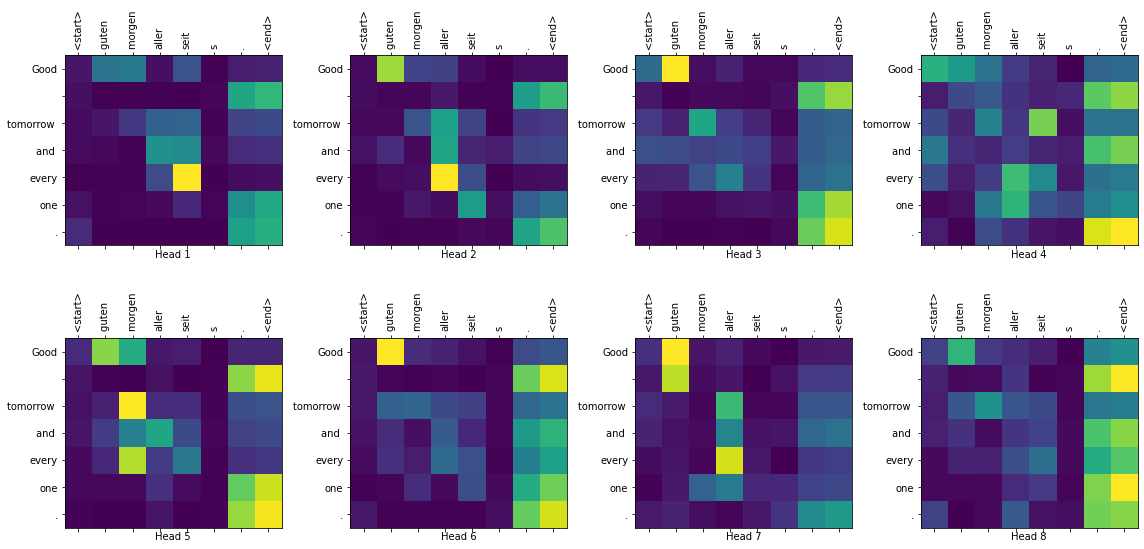

In [122]:
translate("guten morgen allerseits.", plot='decoder_layer4_block2')